# Model to Classify Start positions in Kinect dataset

Section for configurations and imports.

In [1]:
import os 
import tempfile

import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras

# MLflow dashboard
import mlflow
mlflow.set_tracking_uri('http://35.228.45.76:5000')
os.environ['GOOGLE_APPLICATION_CREDENTIALS']='./mlflow-312506-8cfad529f4fd.json'

# Import data augmentation
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from augmentation.methods import *

ModuleNotFoundError: No module named 'augmentation.methods'

In [29]:
import warnings
warnings.simplefilter('ignore')

In [30]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [31]:
random_state = 47
np.random.seed(random_state)

In [32]:
physical_devices = tf.config.experimental.list_physical_devices( 'GPU' )
print( 'Num GPUs Available: ', len( physical_devices ) )
if len( physical_devices ) > 0:
    tf.config.experimental.set_memory_growth( physical_devices[0], True )

Num GPUs Available:  1


# 1. Data Preparation

## 1.1 Load Kinect files with marked start and stop frames in one-hot encoding. We're only interested in the 'start' column.

In [33]:
data_path = '../../datasets/marked_start_end/'

df = None

In [34]:
for file in os.listdir(data_path):
    if file.endswith('.csv') and 'kinect' in file:
        try:
            dataset = pd.read_csv(data_path + file)
            dataset.drop(columns=['FrameNo'], inplace=True)
            dataset.drop(columns=['end'], inplace=True)

            if df is None:
                df = dataset
            else:
                df = pd.concat((df, dataset), ignore_index=True)

        except IOError as e:
            print('Error in reading file: ', e)

print(df.shape)

(37782, 40)


## 1.2 Data Augmentation

In [35]:
df = mirror(df,'x', append=True)
print(df.shape)

(75564, 40)


## 1.3 Check Class Imbalance

This shows the small fraction of start frames.

In [36]:
X = df.drop(columns=['start'])
y = df['start']

In [37]:
print(
    'Total: {}\n\nStart: {} ({:.2f}% of total)\nNone: {} ({:.2f}% of total)\n'
    .format(
      len(y), 
      len(y.values[y.values == 1]),
      len(y.values[y.values == 1]) / len(y),
      len(y.values[y.values == 0]),
      len(y.values[y.values == 0]) / len(y)
    )
  )

Total: 75564

Start: 15628 (0.21% of total)
None: 59936 (0.79% of total)



## 1.3 Oversample the minority class

In [38]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=random_state) # Perform oversamling using SMOTE
resampled_X, resampled_y = sm.fit_resample(X, y)

print(resampled_X.shape)
print(resampled_y.shape)

## 1.5 Split and normalize the data

We already dropped the 'FrameNo' and 'end' columns when the data was loading. <br />
Now, we'll split the dataset into train, validation, and test sets:

- The validation set is used during model fitting to evaluate the loss and other evaluation metrics.
- The test set is unused during the training phase and is used at the end to evaluate how well the model generalizes to new data (i.e. a holdout set). This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

We also normalize the input features using the sklearn StandardScaler. StandardScaler is only fit using X_train. As we want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(resampled_X, resampled_y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=random_state)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Training labels shape:', y_train.shape)
print('Validation labels shape:', y_val.shape)
print('Test labels shape:', y_test.shape, '\n')

print('Training features shape:', X_train.shape)
print('Validation features shape:', X_val.shape)
print('Test features shape:', X_test.shape)

Training labels shape: (76717,)
Validation labels shape: (19180,)
Test labels shape: (23975,) 

Training features shape: (76717, 39)
Validation features shape: (19180, 39)
Test features shape: (23975, 39)


# 2. Define the Model and Metrics

## 2.1 Layer factory

In [14]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(rate=nodes)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

## 2.2 Model Architecture

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer

def make_model(metrics, layers, optimizer, input_dim, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

# 3. Build the Model

## 3.1 Estimate the initial bias

We're going to keep the initial model's weights in a checkpoint file and load them into each model before training so the model doesn't need to spend the first few epochs just learning that start frames are unlikely. Therefore, we start by estimating the initial bias before defining the model.

In [16]:
neg, pos = np.bincount(y)

initial_bias = np.log([pos/neg])
initial_bias

array([-1.34421315])

## 3.2 Define the Model and Evaluation Metrics

We're using standard evaluation metrics for binary classification problems. 

The **make_model** function returns a model based on parameter values. It uses the Layer Factory for creating the model.

In [17]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Dropout, Flatten

def layerFactory(type, nodes, activation):
    if type == 'Dense':
        if not activation:
            return Dense(units=nodes)
        else:
            return Dense(units=nodes, activation=activation)
    if type == 'Conv1D':
        if not activation:
            return Conv1D(units=nodes)
        else:
            return Conv1D(units=nodes, activation=activation)
    if type == 'MaxPooling1D':
        if not activation:
            return MaxPooling1D(units=nodes)
        else:
            return MaxPooling1D(units=nodes, activation=activation)
    if type == 'Dropout':
        return Dropout(rate=nodes)
    if type == 'Flatten':
        if not activation:
            return Flatten(units=nodes)
        else:
            return Flatten(units=nodes, activation=activation)
    
    # otherwise return dense as default
    return Dense(units=nodes, activation=activation)

In [18]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(layers, input_dim, loss, optimizer, learning_rate=0.001, metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    model = Sequential([
        InputLayer(input_shape=(input_dim))
    ])

    for layer in layers:
        model.add(layerFactory(layer['type'], layer['nodes'], layer['activation']))

    optimizer = tf.keras.optimizers.get(optimizer)
    optimizer.learning_rate.assign(learning_rate)

    model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=metrics)

    print(model.summary())

    return model

In [19]:
output_bias = tf.keras.initializers.Constant(initial_bias)
input_dim = X_train.shape[1]
output_size = 1

units = 64
activation = 'relu'
kernel_initializer = 'he_uniform'
output_activation = 'sigmoid'
optimizer = 'Adam'
learning_rate = 1e-3

LAYERS = [ 
    { 'type': 'Dense', 'nodes':units, 'activation': activation, 'kernel_initializer': kernel_initializer },
    { 'type': 'Dense', 'nodes':units, 'activation': activation, 'kernel_initializer': kernel_initializer },
    { 'type': 'Dropout', 'nodes':0.5, 'activation': '' },
    { 'type': 'Dense', 'nodes':output_size, 'activation': output_activation, 'bias_initializer': initial_bias }
]

model = make_model(layers=LAYERS, input_dim=input_dim, loss='binary_crossentropy', optimizer=optimizer, learning_rate=learning_rate, output_bias=output_bias)

model.predict(X_train[:10])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2560      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,785
Trainable params: 6,785
Non-trainable params: 0
_________________________________________________________________
None


array([[0.45434412],
       [0.48585123],
       [0.41526964],
       [0.42368692],
       [0.4507982 ],
       [0.50262487],
       [0.60073996],
       [0.5046875 ],
       [0.34062624],
       [0.33690605]], dtype=float32)

In [20]:
results = model.evaluate(X_train, y_train, batch_size=2048, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.7825


In [21]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

## 3.3 Add Class Weights

In [22]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

class_weight_dict = dict(enumerate(class_weights))

print('Weight for class 0:', class_weights[0])
print('Weight for class 1:', class_weights[1])

Weight for class 0: 1.0067319300824105
Weight for class 1: 0.9933575035607924


# 4. MLflow Experimentation

## 4.1 Define learning parameters for all models

In [23]:
from keras.callbacks import EarlyStopping

EPOCHS = 500
BATCH_SIZE = 2000

early_stopping = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

## 4.2 Define Experimentation Configurations

The Model signature in MLflow defines the schema of a model's inputs and outputs. 

In [24]:
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, ColSpec

input_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_z"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_z"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_z"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_z"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_z"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "left_hand_z"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "right_hand_z"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_z"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_z"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_z"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_z"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "left_foot_z"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
    ColSpec("double", "right_foot_z"),
])
output_schema = Schema([
    ColSpec("double", "head_x"),
    ColSpec("double", "head_y"),
    ColSpec("double", "head_z"),
    ColSpec("double", "left_shoulder_x"),
    ColSpec("double", "left_shoulder_y"),
    ColSpec("double", "left_shoulder_z"),
    ColSpec("double", "left_elbow_x"),
    ColSpec("double", "left_elbow_y"),
    ColSpec("double", "left_elbow_z"),
    ColSpec("double", "right_shoulder_x"),
    ColSpec("double", "right_shoulder_y"),
    ColSpec("double", "right_shoulder_z"),
    ColSpec("double", "right_elbow_x"),
    ColSpec("double", "right_elbow_y"),
    ColSpec("double", "right_elbow_z"),
    ColSpec("double", "left_hand_x"),
    ColSpec("double", "left_hand_y"),
    ColSpec("double", "left_hand_z"),
    ColSpec("double", "right_hand_x"),
    ColSpec("double", "right_hand_y"),
    ColSpec("double", "right_hand_z"),
    ColSpec("double", "left_hip_x"),
    ColSpec("double", "left_hip_y"),
    ColSpec("double", "left_hip_z"),
    ColSpec("double", "right_hip_x"),
    ColSpec("double", "right_hip_y"),
    ColSpec("double", "right_hip_z"),
    ColSpec("double", "left_knee_x"),
    ColSpec("double", "left_knee_y"),
    ColSpec("double", "left_knee_z"),
    ColSpec("double", "right_knee_x"),
    ColSpec("double", "right_knee_y"),
    ColSpec("double", "right_knee_z"),
    ColSpec("double", "left_foot_x"),
    ColSpec("double", "left_foot_y"),
    ColSpec("double", "left_foot_z"),
    ColSpec("double", "right_foot_x"),
    ColSpec("double", "right_foot_y"),
    ColSpec("double", "right_foot_z"),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

## 4.3 Functions used in the experimentation

For creating plots and others.

In [25]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

def plot_loss(history, label, n):
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  print('Total: ', np.sum(cm[1]))


def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

## 4.4 Start run

Starting a run which fits the model according to chosen parameter values, then makes predictions and saves selected values to MLflow dashboard.

al_precision: 0.9629 - val_recall: 0.9917 - val_auc: 0.9976 - val_prc: 0.9971
Epoch 91/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0628 - tp: 38079.0000 - fp: 1234.0000 - tn: 36868.0000 - fn: 536.0000 - accuracy: 0.9769 - precision: 0.9686 - recall: 0.9861 - auc: 0.9972 - prc: 0.9969 - val_loss: 0.0576 - val_tp: 9316.0000 - val_fp: 301.0000 - val_tn: 9455.0000 - val_fn: 108.0000 - val_accuracy: 0.9787 - val_precision: 0.9687 - val_recall: 0.9885 - val_auc: 0.9977 - val_prc: 0.9973
Epoch 92/500
39/39 [==============================] - 0s 8ms/step - loss: 0.0620 - tp: 38088.0000 - fp: 1213.0000 - tn: 36889.0000 - fn: 527.0000 - accuracy: 0.9773 - precision: 0.9691 - recall: 0.9864 - auc: 0.9973 - prc: 0.9969 - val_loss: 0.0570 - val_tp: 9328.0000 - val_fp: 316.0000 - val_tn: 9440.0000 - val_fn: 96.0000 - val_accuracy: 0.9785 - val_precision: 0.9672 - val_recall: 0.9898 - val_auc: 0.9977 - val_prc: 0.9973
Epoch 93/500
39/39 [==============================] - 0s 8ms/

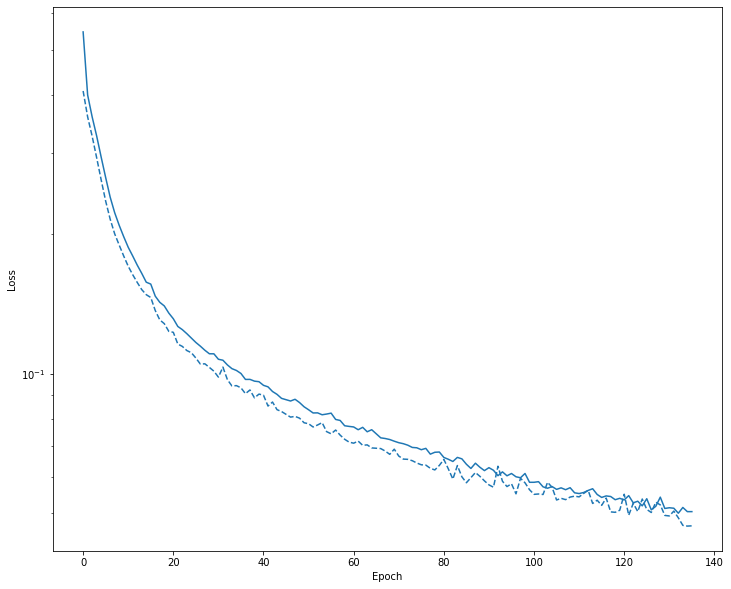

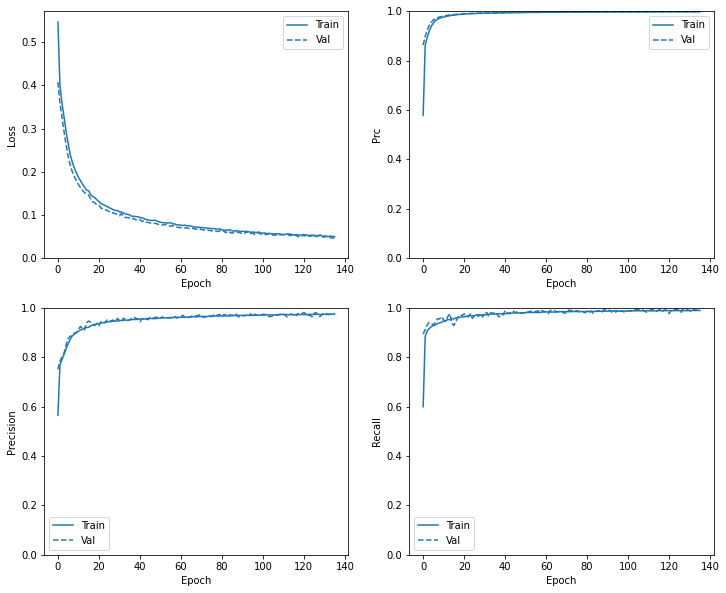

loss :  0.05102673918008804 /n
tp :  11719.0 /n
fp :  250.0 /n
tn :  11828.0 /n
fn :  178.0 /n
accuracy :  0.9821480512619019 /n
precision :  0.9791126847267151 /n
recall :  0.9850382208824158 /n
auc :  0.9979581236839294 /n
prc :  0.9974269270896912 /n
True Negatives:  11828
False Positives:  250
False Negatives:  178
True Positives:  11719
Total:  11897


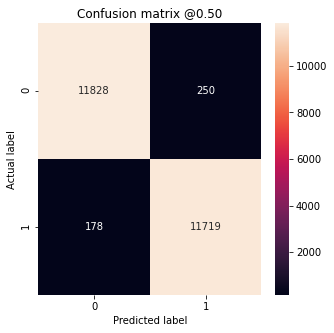

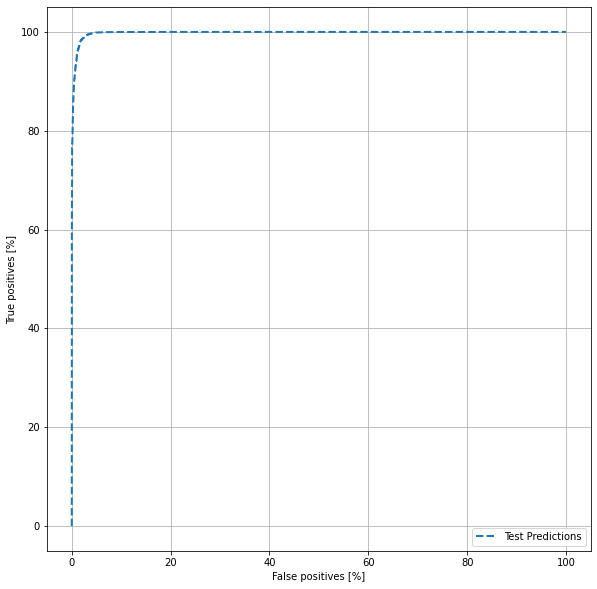

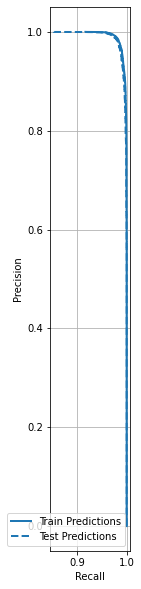

INFO:tensorflow:Assets written to: C:\Users\angel\AppData\Local\Temp\tmp1ffiviw_\model\data\model\assets


In [26]:
model_name = 'cut_start_kinect'

with mlflow.start_run(run_name=model_name) as run:

    run_id = run.info.run_id

    model = make_model(metrics=METRICS, 
                        layers=LAYERS, 
                        loss='binary_crossentropy', 
                        optimizer=optimizer, 
                        learning_rate=learning_rate, 
                        output_bias=initial_bias, 
                        input_dim=input_dim)
    model.load_weights(initial_weights)
    model.layers[-1].bias.assign([0.0])
    
    with tf.device('/CPU:0'):
        history = model.fit(
            x=X_train, 
            y=y_train, 
            class_weight=class_weight_dict, 
            validation_data=(X_val, y_val), 
            shuffle=True, 
            epochs=EPOCHS, 
            verbose=1,
            batch_size=BATCH_SIZE, 
            callbacks=[early_stopping])

        # Plot training history
        plot_loss(history, "Bias", 0)
        plt.savefig("loss.jpg")
        mlflow.log_artifact("loss.jpg")
        plt.show()
        
        # Plot and log metrics
        predictions_train = model.predict(X_train)
        predictions_test = model.predict(X_test)

        plot_metrics(history)
        plt.savefig("metrics.jpg")
        mlflow.log_artifact("metrics.jpg")
        plt.show()

        # Confusion matrix
        results = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=0)
        for name, value in zip(model.metrics_names, results):
            print(name, ': ', value, '/n')
        plot_cm(y_test, predictions_test)
        plt.savefig("cm.jpg")
        mlflow.log_artifact("cm.jpg")
        plt.show()

        # ROC Curve
        plot_roc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("roc.jpg")
        mlflow.log_artifact("roc.jpg")
        plt.show()

        # Precision-Recall Curve (PRC)
        plot_prc("Train Predictions", y_train, predictions_train, color=colors[0])
        plot_prc("Test Predictions", y_test, predictions_test, color=colors[0], linestyle='--')
        plt.legend(loc='lower right')
        plt.savefig("prc.jpg")
        mlflow.log_artifact("prc.jpg")
        plt.show()
        
        # Log model, scaler, model parameters to MLflow
        mlflow.log_param("units", units)
        mlflow.log_param("activation", activation)
        mlflow.log_param("kernel_initializer", kernel_initializer)
        mlflow.log_param("output activation", output_activation)
        mlflow.log_param("optimizer", optimizer)
        mlflow.log_param("learning rate", learning_rate)
        mlflow.log_param("batch size", BATCH_SIZE)
        mlflow.log_metric("accuracy", results[5])
        mlflow.log_metric("average precision score", results[6])
        mlflow.log_metric("recall", results[7])
        mlflow.log_metric("auc", results[8])

        mlflow.keras.log_model(model, model_name, signature=signature)
        mlflow.sklearn.log_model(scaler, 'InputScaler')

## 5. Register Model

In [27]:
model_uri = "runs:/{}/cut_start_kinect".format(run.info.run_id)
mv = mlflow.register_model(model_uri, "cut_start_kinect")
print("Name: {}".format(mv.name))
print("Version: {}".format(mv.version))

Registered model 'cut_start_kinect' already exists. Creating a new version of this model...
2021/05/14 22:53:43 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cut_start_kinect, version 4
Name: cut_start_kinect
Version: 4
Created version '4' of model 'cut_start_kinect'.
